In [1]:
import torch
import numpy as np
import pandas as pd
import glob ## to grap the files easily 
import matplotlib.pyplot  as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2 ## help to read image 
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from torch.utils.data import DataLoader


## Loading the images and creating the labels

Let's define the trasformation we need for vg16

In [2]:
from torchvision import transforms
# Define the preprocessing transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),  # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),  # Crop the center 224x224 pixels (since vg16 takes an 224x224 image)
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet's mean
                         #std=[0.229, 0.224, 0.225])  # Normalize using ImageNet's std deviation
])

## Let's define the augumention

In [3]:
# Define the PyTorch data augmentation pipeline using torchvision.transforms
demo_datagen = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),  # Rotation range of 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Width and height shift range of 5%
    transforms.RandomAffine(degrees=0, shear=0.05),  # Shear range of 5%
    transforms.ColorJitter(brightness=(0.1, 1.5)),  # Brightness range of 0.1 to 1.5
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomVerticalFlip(),  # Vertical flip
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image
])

## Loading the images
### Appending the paths for tumor and and healthy scans

In [4]:
tumor_paths = []
healthy_paths  = []

# cv2 - It reads in BGR format by default
for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):  
    tumor_paths.append(f)

for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
    healthy_paths.append(f)


tumor_paths= np.array(tumor_paths)
healthy_paths= np.array(healthy_paths)

tumor_label = np.ones(tumor_paths.shape[0], dtype=np.float32)
healthy_label = np.zeros(healthy_paths.shape[0], dtype=np.float32)

images = np.concatenate((tumor_paths, healthy_paths,), axis=0)
labels = np.concatenate((tumor_label, healthy_label))

In [5]:
print("the malignant are:",tumor_paths.shape)
print("the bening are:",healthy_paths.shape)
print("the total number is",images.shape)

the malignant are: (86,)
the bening are: (85,)
the total number is (171,)


# Visualization

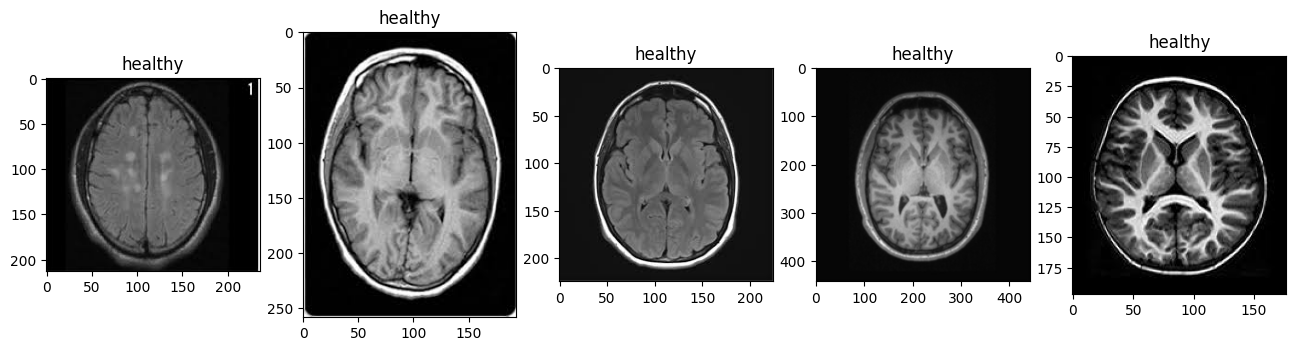

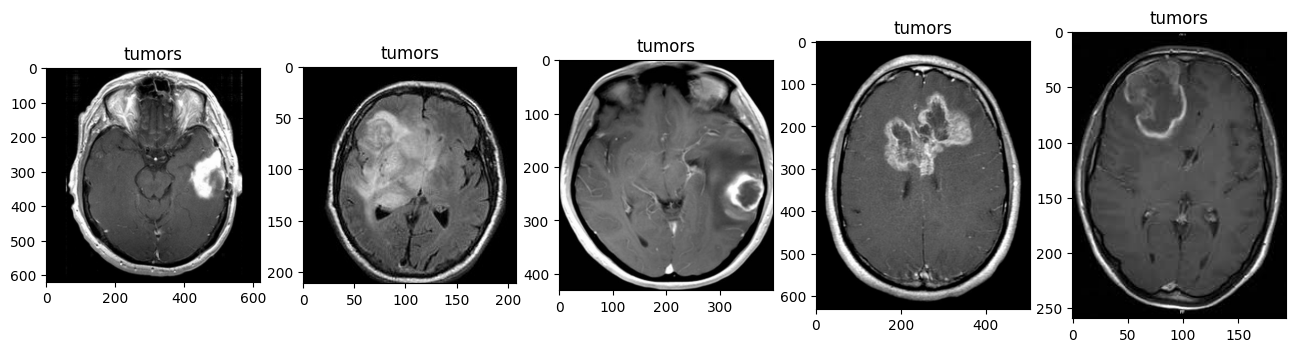

In [6]:
def  plot_random(healthy,tumor, num = 5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0],num,replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0],num,replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num): ## matplotlib starts from 1 differently from when using python
        plt.subplot(1,num, i+1) # 1 row with 5 columns, i want to allocate the neext image in the position i+1
        plt.title("healthy")

        img = healthy_imgs[i]
        img = cv2.imread(img)  # Reads in BGR format (the output is in BRG) 
        plt.imshow(img)
    
    plt.figure(figsize=(16,9))
    for i in range(num): ## matplotlib starts from 1 differently from when using python
        plt.subplot(1,num, i+1) # 1 row with 5 columns, i want to allocate the neext image in the position i+1
        plt.title("tumors")
        img = tumor_imgs[i]
        img = cv2.imread(img)  # Reads in BGR format
        plt.imshow(img)
plot_random(healthy_paths,tumor=tumor_paths, num = 5)

## Let's define the custom dataset

In [7]:
class MRI(Dataset):
    def __init__(self,images_paths,labels,Basic_trasforms,Augumentation = None):
        self.images_paths = images_paths
        self.labels = labels
        self.Basic_trasforms = Basic_trasforms
        self.Augumentation = Augumentation
        

    def __len__(self):
        return self.images_paths.shape[0]
    
    def __getitem__(self, index):
        img_path = self.images_paths[index]
        img= cv2.imread(img_path) ## this reads in BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB since we use pytorch and returnns a NumpyArray
        img = self.Basic_trasforms(img)
        if  self.Augumentation:
             img = self.Augumentation(img)
        label = self.labels[index]
        return img, label

## Let's split the dataset

In [13]:
X_train, X_test, y_train, y_test= train_test_split(images, labels, test_size=0.30, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test= train_test_split( X_test, y_test, test_size=0.50, random_state=42,stratify=y_test)

Number of instances in the training

In [14]:
y_train.shape

(119,)

# Label distribution across Train, val and test

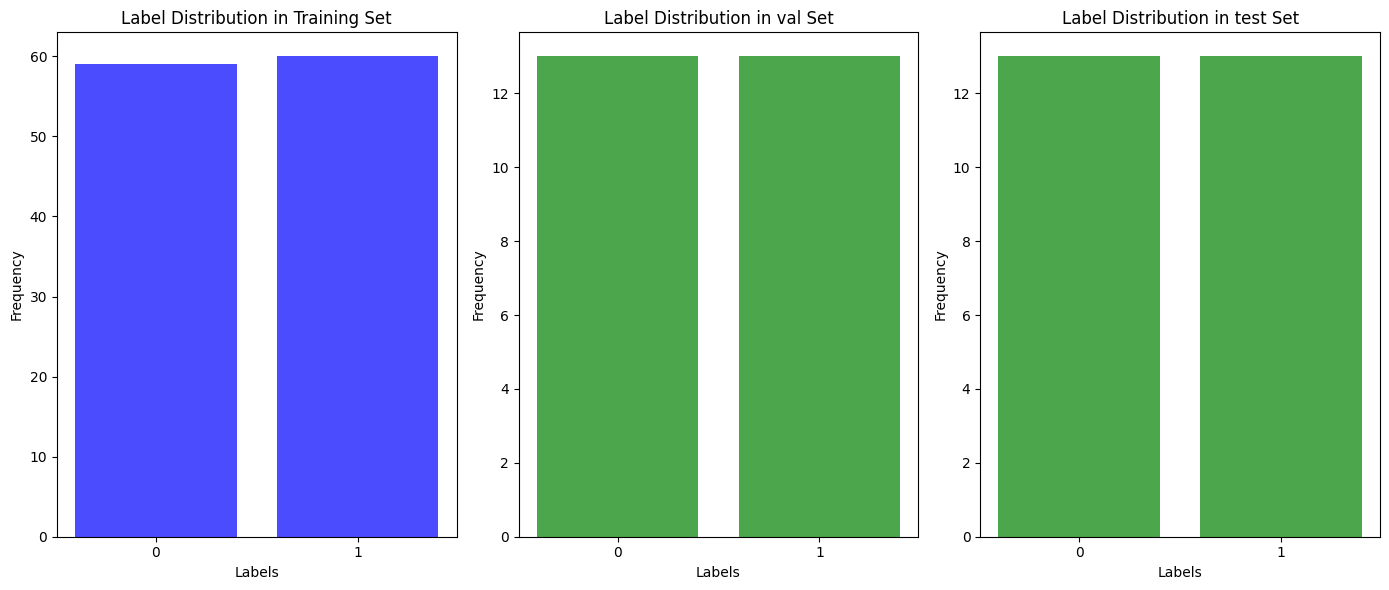

In [15]:
plt.figure(figsize=(14, 6))

# Histogram for training labels
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=np.arange(-0.5, 2), rwidth=0.8, color='blue', alpha=0.7)
plt.title('Label Distribution in Training Set')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 2))

# Histogram for val labels
plt.subplot(1, 3, 2)
plt.hist(y_val, bins=np.arange(-0.5, 2), rwidth=0.8, color='green', alpha=0.7)
plt.title('Label Distribution in val Set')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 2))

# Histogram for test labels
plt.subplot(1, 3, 3)
plt.hist(y_test, bins=np.arange(-0.5, 2), rwidth=0.8, color='green', alpha=0.7)
plt.title('Label Distribution in test Set')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 2))


plt.tight_layout()
plt.show()

In [16]:
X_val.shape

(26,)

## Let's create the validation and training dataset

In [17]:
traning_dataset = MRI(images_paths=X_train,labels=y_train,Basic_trasforms=transform,Augumentation=demo_datagen)

In [18]:
validation_dataset = MRI(images_paths=X_val,labels=y_val,Basic_trasforms=transform)

In [19]:
test_dataset = MRI(images_paths=X_test,labels=y_test,Basic_trasforms=transform)

## Let's define the model

In [26]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # If using CUDA
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



class CNNWithVGG16(nn.Module):
    def __init__(self, num_classes=1):  # Adjust `num_classes` as needed
        super(CNNWithVGG16, self).__init__()
        set_seed(seed_value=42)
        # Load the pre-trained VGG16 model
        self.base_model = models.vgg16(weights="VGG16_Weights.DEFAULT")
        
        # Remove the original VGG16 classifier
        self.base_model.classifier = nn.Identity()
        
        # Freeze the feature extraction part of VGG16 to prevent updating weights during training
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        self.batch_norm = nn.BatchNorm1d(25088)  # Adjust the `num_features` as needed based on VGG16 output

        

        # Define custom fully connected layers for classification
        # Adjust the `in_features` based on the output of your VGG16 feature extraction part
        self.fc_model = nn.Sequential(

        nn.Linear(in_features=25088, out_features=1600),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=1600, out_features=1))
    

    def forward(self, x):
        # Use VGG16 for feature extraction
        x = self.base_model(x)
        
        # Flatten the features extracted by VGG16
        x = x.view(x.size(0), -1) # one vector for each sample
        x = self.batch_norm(x)
        x = nn.ReLU()(x)

        x = self.fc_model(x)
        x = torch.sigmoid(x)
        
        return x

## Batch normalization

### Mathematical Formulation

Given a feature $x$ in a mini-batch, batch normalization transforms $x$ into $\hat{x}$ using the formula:

$$
\hat{x} = \gamma \left( \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \right) + \beta
$$

where:
- $\mu$ is the mean of the mini-batch,
- $\sigma^2$ is the variance of the mini-batch,
- $\gamma$ is a scale parameter (learned),
- $\beta$ is a shift parameter (learned),
- $\epsilon$ is a small constant added for numerical stability.


Benefits:
- Faster Training: It allows the use of higher learning rates, which can speed up the training process.
- Reduces Overfitting: BN has a regularization effect, which can reduce the need for other regularization techniques like dropout, though they can still be used in conjunction.
- Less Sensitive to Initialization: With batch normalization, the network is less sensitive to the initial weights.
Use Cases:
- Batch normalization is widely used in various types of neural networks beyond CNNs, including fully connected networks, recurrent neural networks (RNNs), and generative adversarial networks (GANs). Its versatility and effectiveness make it a staple in the deep learning toolkit.

## Normalization Process
Batch normalization performs the following steps for each mini-batch:

- Calculate Mean and Variance: It computes the mean and variance for the input features over the mini-batch.

- Normalize: It normalizes the input features using the calculated mean and variance, ensuring the features have a mean close to 0 and a standard deviation close to 1.

- Scale and Shift: Finally, BN applies a scale and shift transformation to the normalized features. These are learnable parameters of the model, allowing the network to undo the normalization if that is what is optimal for learning. This step ensures that the batch normalization layer can represent the identity transformation and does not restrict the representational capacity of the network.

## Dropout layer

Adding a dropout layer after pooling, specifically after average pooling (nn.AvgPool2d in your case), can be an effective strategy, but it isn't a hard rule. The placement of dropout layers within a neural network architecture can vary depending on the specific design choices and the intended effect of regularization.

Here's why you might consider placing dropout after pooling layers:

- Reduced Dimensionality: Pooling layers reduce the dimensionality of the feature maps. Applying dropout after pooling means that the regularization is applied to a lower-dimensional representation, which can be computationally more efficient.

- Regularizing Higher-level Features: After pooling, the network has aggregated information over local patches of the input. Applying dropout at this stage can help regularize these higher-level, aggregated features, promoting the learning of more robust features that do not rely on the presence of specific activations.

- Preventing Co-adaptation: Just like with neurons in fully connected layers, neurons in convolutional layers can also co-adapt during training. Applying dropout after pooling helps to prevent this co-adaptation by randomly zeroing feature maps, forcing the network to learn more redundant representations.

## Weight Decay

Weight decay is a form of regularization that discourages large weights in a neural network by adding a penalty term to the loss function. In practice, weight decay is implemented by adding a fraction of the weight values to the loss function, which has the effect of shrinking the weights during training.

Performance Gap: If there is a significant gap between training performance (e.g., accuracy) and validation performance, it could be a sign of overfitting. Weight decay could help reduce this gap by penalizing larger weights and encouraging the model to find simpler patterns that may generalize better.

Weight decay is a regularization technique that helps prevent overfitting by penalizing large weights. The `weight_decay` parameter controls the strength of this regularization. Here's a list of logarithmically spaced values that you can consider when tuning weight decay for your model:

- $0$ (No weight decay, useful as a baseline to understand the impact of adding weight decay)
- $1 \times 10^{-4}$
- $5 \times 10^{-4}$
- $1 \times 10^{-3}$
- $5 \times 10^{-3}$
- $1 \times 10^{-2}$
- $5 \times 10^{-2}$
- $1 \times 10^{-1}$
- $5 \times 10^{-1}$

These values cover a wide range of scales and can help you find the optimal level of regularization for your specific problem. It's common practice to refine your search based on initial results. For instance, if you find that $1 \times 10^{-3}$ performs better than both $1 \times 10^{-4}$ and $1 \times 10^{-2}$, you might want to explore additional values between $1 \times 10^{-4}$ and $1 \times 10^{-3}$, or between $1 \times 10^{-3}$ and $1 \times 10^{-2}$, to fine-tune the weight decay parameter.


## Why do i need to use x.view?
in the code, we have the batch of data for the training/testing so doing this I flatten each data point

## Modelling

Some observations:
- We need to use the model.eval() for 2 reasons:
    - to turn off the dropout at test time
    - to not use the batch normalization for each test batch (just use the mean and variance learnt using the training)

An important remark: when using .eval() i don't turn off the gradient computation! it just changes the forward method behaviour!

## Data augumentation

it's used to generate more heterogeinity in the training samples, basically applying transformation to a given image. so in different time the model see different images

## Let's set the seeds

In [ ]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [22]:
dataloader_training = DataLoader(traning_dataset, batch_size=32, shuffle=True)
dataloader_validation= DataLoader(validation_dataset, batch_size=32, shuffle=True)
dataloader_test= DataLoader(test_dataset, batch_size=32, shuffle=True)

## let's find the best configuration of hyperparameters

## Let's train the best configuration for longer epochs

In [28]:
from sklearn.metrics import f1_score

from torch.optim.lr_scheduler import StepLR

wd = 0.050000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNWithVGG16().to(device)

# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []


#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = CNN().to(device)
lr=1e-6
num_epochs = 100
dataloader_training = DataLoader(traning_dataset, batch_size=32, shuffle=True)
dataloader_validation= DataLoader(validation_dataset, batch_size=32, shuffle=True)
criterion = nn.BCELoss()

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=wd)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)


for epoch in range(num_epochs):
    train_losses=[]
    for index, (batch_features, batch_labels) in enumerate(dataloader_training):
        optimizer.zero_grad() ## Remove the cached gradients 
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        y_hat = model(batch_features)
        loss = criterion(y_hat.squeeze(),batch_labels)
        loss.backward() ## This computes the gradients
        optimizer.step() ## This update the weights

        train_losses.append(loss.item())  

    scheduler.step()  # Adjust the learning rate after each epoch


    epoch_train_loss.append(np.mean(train_losses))
    val_losses = []
    model.eval()
    with torch.no_grad():
        all_labels = []
        all_probabilities = []
        for index, (batch_features, batch_labels) in enumerate(dataloader_validation):
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            y_hat = model(batch_features)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(),  batch_labels))

            # Append predictions and labels for later calculation of AUC
            all_labels.extend(batch_labels)
            all_probabilities.extend(y_hat)
            val_losses.append(loss.item()) 
        epoch_val_loss.append(np.mean(val_losses))
            


#------------------------------------------------------------------
threshold = 0.5
#------------------------------------------------------------------
predicted_labels = (all_probabilities >= threshold).int()
# Calculate accuracy, recall, precision using the best threshold
accuracy = accuracy_score( all_labels,  predicted_labels)
recall = recall_score( all_labels,  predicted_labels)
precision = precision_score( all_labels, predicted_labels)
fpr, tpr, thresholds = roc_curve( all_labels,  all_probabilities )
# Calculate AUC
roc_auc = auc(fpr, tpr)
rounded_roc_auc = round(roc_auc, 2)

# Round  to 3 decimal places
rounded_accuracy = round(accuracy, 2)
rounded_recall = round(recall, 2)
rounded_precision  = round(precision,2)
    #------------------------------------------------------------------
print('WeightDecay: {:.6f}\tROC AUC: {:.6f}\tAccuracy: {:.6f}\tRecall: {:.6f}\tPrecision: {:.6f}'.format(wd,  rounded_roc_auc, rounded_accuracy, rounded_recall,rounded_precision))
#------------------
        

0.5700000000000001
WeightDecay: 0.050000	ROC AUC: 0.930000	Accuracy: 0.880000	Recall: 0.920000	Precision: 0.860000


## Here the losses

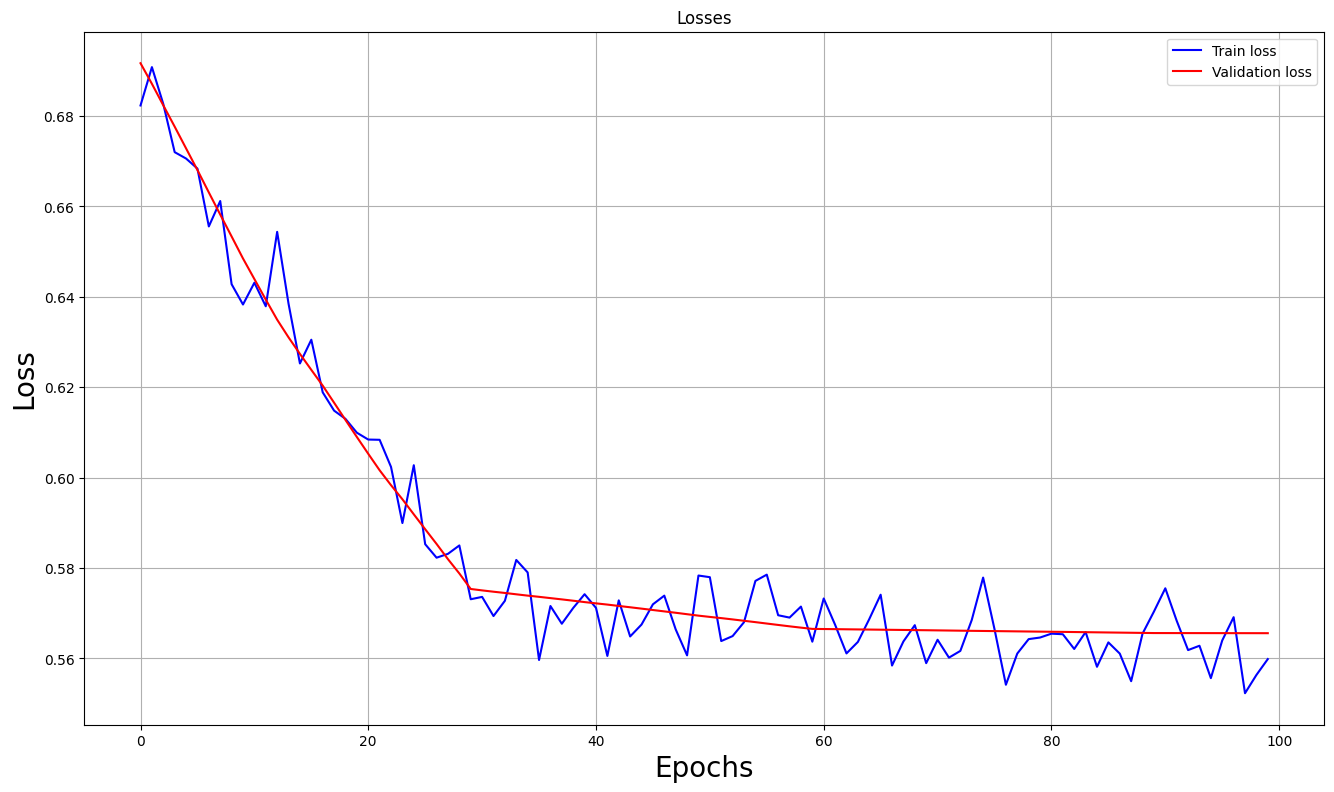

In [29]:
plt.figure(figsize=(16,9))
plt.title("Losses")
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.show()

## Let's test the model on unseen data

In [36]:
model.eval()
with torch.no_grad():
    all_labels = []
    all_probabilities = []
    for index, (batch_features, batch_labels) in enumerate(dataloader_test):
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        y_hat = model(batch_features)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(),  batch_labels))

        # Append predictions and labels for later calculation of AUC
        all_labels.extend(batch_labels)
        all_probabilities.extend(y_hat)
        val_losses.append(loss.item()) 
        
    epoch_val_loss.append(np.mean(val_losses))
        

    #------------------------------------------------------------------
    threshold = 0.5
    all_probabilities = torch.tensor(all_probabilities)
    predicted_labels = (all_probabilities >= threshold).int()
    #------------------------------------------------------------------

    # Calculate accuracy, recall, precision using the best threshold
    accuracy = accuracy_score( all_labels,  predicted_labels)
    recall = recall_score( all_labels,  predicted_labels)
    precision = precision_score( all_labels, predicted_labels)
    fpr, tpr, thresholds = roc_curve( all_labels,  all_probabilities )
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    rounded_roc_auc = round(roc_auc, 2)

    # Round  to 3 decimal places
    rounded_accuracy = round(accuracy, 2)
    rounded_recall = round(recall, 2)
    rounded_precision  = round(precision,2)
    #------------------------------------------------------------------
    print('ROC AUC: {:.6f}\tAccuracy: {:.6f}\tRecall: {:.6f}\tPrecision: {:.6f}'.format( rounded_roc_auc, rounded_accuracy, rounded_recall,rounded_precision))
    #------------------

ROC AUC: 0.850000	Accuracy: 0.730000	Recall: 0.540000	Precision: 0.880000


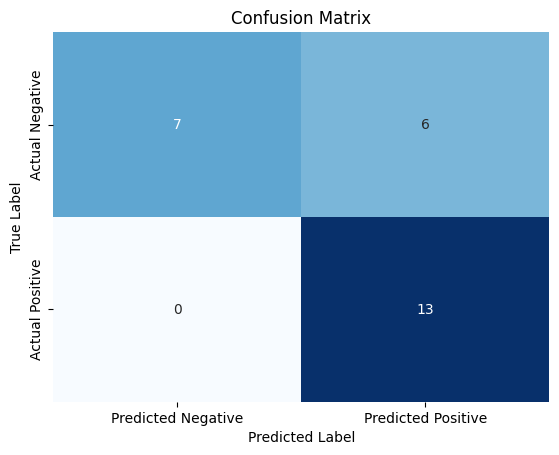

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels,  predicted_labels)

# Plot the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Measuring the magnitude of the learned weights

In [33]:
model_children = list(model.children())
model_children
for child in model.children():
    for layer in child.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            # Get the weight of the layer as a numpy array
            weight = layer.weight.data.cpu().numpy()
            # Calculate the L2 norm of the weight
            weight_l2_norm = np.linalg.norm(weight)
            print(f"L2 norm of the weights for layer {layer}: {weight_l2_norm:.4f}")

L2 norm of the weights for layer Linear(in_features=25088, out_features=1600, bias=True): 22.6301
L2 norm of the weights for layer Linear(in_features=1600, out_features=1, bias=True): 0.5752


In general, norms in the range of 1-10 are fairly typical for neural network weights, especially in smaller or moderately-sized networks. However, without context about the performance of your model and the complexity of the task, it's difficult to say definitively whether these norms indicate that weight decay is necessary.

## Let's visualize the loss looking for overfitting 

## Let's look at the filter learnt during the training

In [35]:
no_of_layers = 0
conv_layers = []

In [ ]:
model_children = list(model.children())
model_children

[VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2, pa

In [ ]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

## Extracting an image

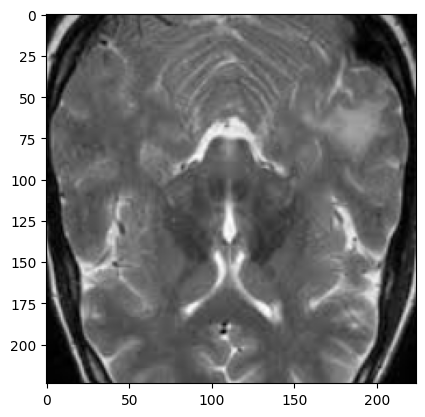

In [ ]:
img = validation_dataset[3][0]

# If the tensor is on a GPU, move it back to CPU and convert to numpy
img = img.cpu().numpy()

# Permute the dimensions from [C, H, W] to [H, W, C] for display with imshow
img = np.transpose(img, (1, 2, 0))

# Display the image
plt.imshow(img)
plt.show()

In [ ]:
results = [conv_layers[0](img)] ### this produce the k feature maps for img
for i in range(1, len(conv_layers)): ## this does the same for all the others  conv layers
    results.append(conv_layers[i](results[-1])) ## basically, here i use the output of the previous layer (not the input image) as the input for the next
outputs = results

IndexError: list index out of range

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

Some observations:
- the brighter areas are the ones that are interesting for a given kernel
- there are 6 kernels in the first layer
- there are 16 kernels in the second layer